In [1]:
import pandas as pd

# Load the data
file_path = r"C:\Users\Bala Bhanu Prakash\Downloads\indigo passenger data (apr14-dec24).csv"
df = pd.read_csv(file_path)

# Convert MONTH to datetime and PASSENGERS to integer
df['MONTH'] = pd.to_datetime(df['MONTH'], format='%B %Y')
df['PASSENGERS'] = df['PASSENGERS'].str.replace(',', '').astype(int)

# Sort by date
df = df.sort_values('MONTH').reset_index(drop=True)


In [2]:
import numpy as np

# Create a binary COVID indicator for March 2020 - early 2021
df['COVID_EFFECT'] = np.where((df['MONTH'] >= '2020-03-01') & (df['MONTH'] <= '2021-08-01'), 1, 0)


In [3]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['PASSENGERS'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -1.4323683493016706
p-value: 0.5666637605903866


In [4]:
df['DIFF_PASSENGERS'] = df['PASSENGERS'].diff().dropna()


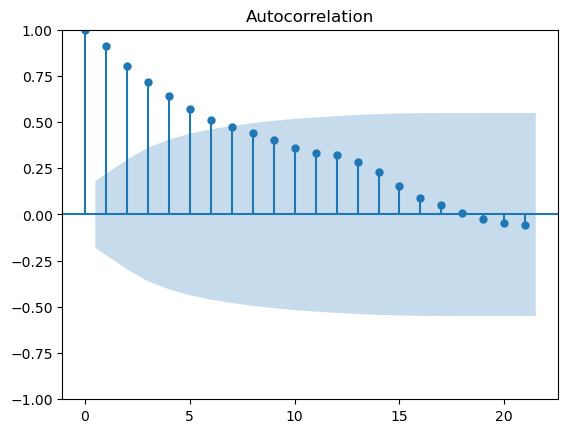

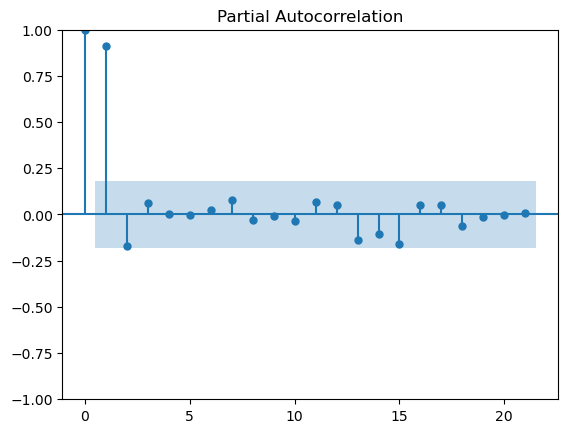

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# ACF and PACF plots
plot_acf(df['PASSENGERS'])
plot_pacf(df['PASSENGERS'])
plt.show()


In [7]:
# Example parameter values (you will need to adjust these based on your analysis)
p = 1  # Autoregressive order
d = 1  # Differencing order (1 if data is non-stationary)
q = 1  # Moving average order

P = 1  # Seasonal autoregressive order
D = 1  # Seasonal differencing order
Q = 1  # Seasonal moving average order
s = 12  # Seasonal period (12 for monthly data with yearly seasonality)


In [8]:
import statsmodels.api as sm

# Define the SARIMA model with exogenous variable
model = sm.tsa.SARIMAX(df['PASSENGERS'], exog=df[['COVID_EFFECT']], 
                       order=(p, d, q), seasonal_order=(P, D, Q, s))

# Fit the model
model_fit = model.fit(disp=False)
print(model_fit.summary())


                                     SARIMAX Results                                      
Dep. Variable:                         PASSENGERS   No. Observations:                  117
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1546.499
Date:                            Fri, 16 Aug 2024   AIC                           3104.998
Time:                                    19:17:02   BIC                           3120.865
Sample:                                         0   HQIC                          3111.426
                                            - 117                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
COVID_EFFECT -1.073e+06   3.56e+05     -3.015      0.003   -1.77e+06   -3.75e+05
ar.L1           -0.2046      

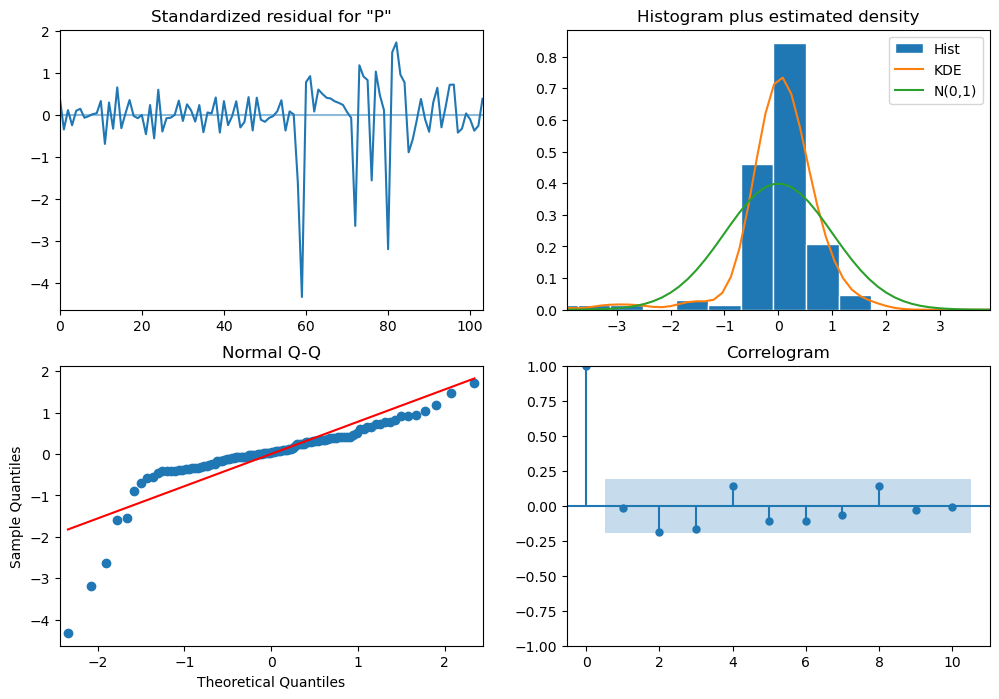

In [9]:
# Residual diagnostics
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()


In [12]:
# Forecast the next 6 months (exog=[0] for no COVID effect)
future_months = pd.date_range(start='2024-01-01', periods=6, freq='MS')
forecast = model_fit.get_forecast(steps=6, exog=[[0]]*6)

# Output forecasted values
forecast_values = forecast.predicted_mean.round(0).astype(int)
print(forecast_values)

# Combine forecast with dates
forecast_df = pd.DataFrame({'MONTH': future_months, 'PASSENGERS_FORECAST': forecast_values})


117    8147916
118    8084789
119    8540809
120    8131031
121    8289904
122    8251773
Name: predicted_mean, dtype: int32


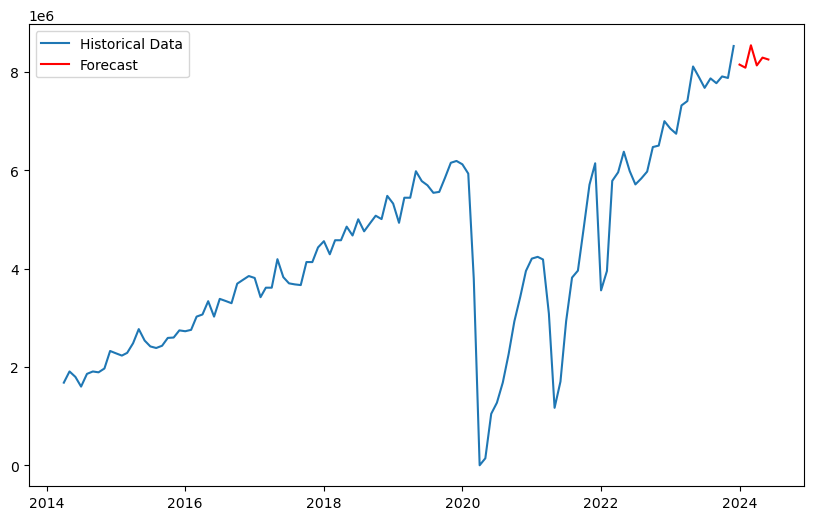